Import package yang dibutuhkan

In [1]:
import torch
import torch.nn as nn

from forecast import multi_steps_forecasting, plot_multisteps_forecasting
from gru_model import GRUModel
from my_dataloader import MyDataset
from trainer import fit


Cek apakah komputer memiliki kartu grafis jika memiliki kartu grafis PyTorch akan menggunakan kartu grafis

In [2]:
cuda = True if torch.cuda.is_available() else False

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

torch.manual_seed(125)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(125)

Persiapkan dataset, muat dataset dari csv

In [3]:
batch_size = 100
n_iters = 12000
window_size = 60

train_dataset = MyDataset(window_size,'data/monthly-beer-production-in-austr.csv','Monthly beer production')
test_dataset = MyDataset(window_size,'data/monthly-beer-production-in-austr.csv','Monthly beer production')

num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)



In [4]:
input_dim = 1
hidden_dim = 256
layer_dim = 1  
output_dim = 1

model = GRUModel(input_dim, hidden_dim, layer_dim, output_dim)

if torch.cuda.is_available():
    model.cuda()

criterion = nn.MSELoss()
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters())

seq_dim = window_size

Train model

In [5]:
fit(num_epochs, optimizer, test_loader, train_loader, model, criterion, input_dim, seq_dim)
model.load_state_dict(torch.load("gru_weight.pt"))
model = model.eval()


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Iteration: 500. Loss: 0.0038563087582588196.
Iteration: 1000. Loss: 0.00206716638058424.
Iteration: 1500. Loss: 0.0027206840459257364.
Iteration: 2000. Loss: 0.0025047557428479195.
Iteration: 2500. Loss: 0.002270839177072048.
Iteration: 3000. Loss: 0.001097846427001059.
Iteration: 3500. Loss: 0.0014637033455073833.
Iteration: 4000. Loss: 0.0014806052204221487.
Iteration: 4500. Loss: 0.001524181105196476.
Iteration: 5000. Loss: 0.00030978675931692123.
Iteration: 5500. Loss: 0.0008738096803426743.
Iteration: 6000. Loss: 0.0002249917306471616.
Iteration: 6500. Loss: 0.0004374078707769513.
Iteration: 7000. Loss: 0.00028041354380548.
Iteration: 7500. Loss: 0.00013955787289887667.
Iteration: 8000. Loss: 0.00024114406551234424.
Iteration: 8500. Loss: 5.792851879959926e-05.
Iteration: 9000. Loss: 2.960596975754015e-05.
Iteration: 9500. Loss: 1.4428418580791913e-05.
Iteration: 10000. Loss: 9.724413757794537e-06.
Iteration: 10500. Loss: 8.873979822965339e-06.
Iteration: 11000. Loss: 7.2747818194

Tampilkan hasil prediksi untuk 10 timestep ke depan

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


[0.37668595 0.41710204 0.43758917 0.53006744 0.55637854 0.5730258
 0.48809847 0.43623716 0.48317882 0.4548024 ]


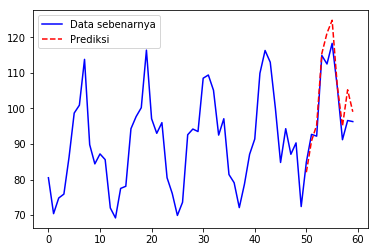

In [6]:
n_th_sample = 18
steps = 10

sample, true_prediction = train_dataset[n_th_sample]
sample1, _ = train_dataset[n_th_sample + steps]
scale = train_dataset.get_scale()
multi_step_prediction_results = multi_steps_forecasting( model, steps, sample)
plot_multisteps_forecasting(scale,multi_step_prediction_results, sample1)